# TO DO

- [ ] re-estimate without buildings constructed in 1979
- [ ] re-estimate with diff census attrs
- [x] re-estimate w/ + w/o buildings built < 2007
- [ ] check variability of census attrs over time
- [ ] map of eviction data (hexes)
- [x] redo table 1 by rates across all addresses
- [x] redo rd plot for pre 2013 evictions and post 2013 evictions
- [x] subtract evictions in year 2017??
- [ ] dedupe evictions at same addr on same date for same tenants? shouldn't be greater than max unit count
- [ ] use householder exemption in assessor records to infer ownership!

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import statsmodels.formula.api as smf
%matplotlib inline

# Load data 

In [2]:
asr = pd.read_csv('../../../2021_02_summer/evic_paper/data/asr_grouped_by_yr_w_geom.csv', dtype={'fipscd': str})
ev = pd.read_csv('../../../2021_02_summer/evic_paper/data/ev_matched_w_fips.csv')
asr_all = pd.read_csv('../data/assessor_2007-2016_fips_jun_2021.csv')

/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (2,8,11,17,46) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Validate pre-processing 

\# matched evictions should match the number of evictions in the assessor file

In [3]:
assert len(ev[~pd.isnull(ev['asr_index'])]) == asr['ev_count'].sum()

Only counting evictions after 2007

In [4]:
assert (asr['ev_count'] == asr['ev_count_post_07']).all()

Make sure we're comparing like to like

In [5]:
assert ev['year'].min() == 2007

In [6]:
assert ev['year'].max() == 2016

In [7]:
assert asr['asr_yr'].min() == 2007

In [8]:
assert asr['asr_yr'].max() == 2016

# Describe data processing/filtering steps

In [9]:
print('{0} eviction records after cleaning'.format(ev.shape[0]))

21802 eviction records after cleaning


In [10]:
print("{0} total assessor records considered".format(asr_all.shape[0]))

1978687 total assessor records considered


In [11]:
print("{0} assessor records after grouping by address and assessed year".format(asr.shape[0]))

1553397 assessor records after grouping by address and assessed year


In [12]:
print("{0} evictions ({1}%) were matched to assessor records".format(
    len(ev[~pd.isnull(ev['asr_index'])]),
    np.round(len(ev[~pd.isnull(ev['asr_index'])]) / len(ev) * 100,1)))

20136 evictions (92.4%) were matched to assessor records


In [13]:
asr_rc_eligible = asr[asr['any_rc_eligibility'] == 1] # all rc eligible
print("{0} evictions across {1} rent control eligible assessor records".format(asr_rc_eligible['ev_count'].sum(), len(asr_rc_eligible)))

14259 evictions across 349607 rent control eligible assessor records


In [14]:
asr_rc_eligible_valid_units = asr_rc_eligible[asr_rc_eligible['total_units'] > 0]
print("{0} evictions assigned to {1} rent control eligible assessor records with valid unit counts".format(asr_rc_eligible_valid_units['ev_count'].sum(), len(asr_rc_eligible_valid_units)))

13963 evictions assigned to 344513 rent control eligible assessor records with valid unit counts


In [15]:
print("{0} assessor records with {1} evictions dropped due to unreliable unit counts".format(
    asr_rc_eligible.shape[0] - asr_rc_eligible_valid_units.shape[0],
    asr_rc_eligible.loc[asr_rc_eligible['total_units']<=0, 'ev_count'].sum()))

5094 assessor records with 296 evictions dropped due to unreliable unit counts


In [16]:
asr['any_ev'] = (asr['ev_count'] > 0).astype(int)
asr['pre_1980'] = (asr['year_built_max'] < 1980)
asr['built_1980'] = None
asr.loc[asr['pre_1980'], 'built_1980'] = 'before'
asr.loc[~asr['pre_1980'], 'built_1980'] = 'after'
asr['ev_per_unit'] = asr['ev_count'] / asr['total_units']

In [17]:
ev = ev.merge(asr, left_on='asr_index', right_on='index', suffixes=('_ev', '_asr'))
print(ev.shape)

(20136, 59)


In [18]:
ev = ev[(ev['total_units'] > 0)]
print(ev.shape)

(19199, 59)


In [19]:
ev = ev[(ev['any_rc_eligibility'] == 1)]
print(ev.shape)

(13963, 59)


#### Table 1

In [20]:
ev.loc[pd.isnull(ev['type']), 'type'] = 'unknown'
type_counts = ev.groupby(['built_1980', 'type']).agg(count=('index_ev', 'nunique')).reset_index()
pre_sums = type_counts.groupby('built_1980')['count'].sum()

ev['ev_type_cat'] = 'breach of lease'
ev.loc[ev['type'].isin([
    'OMI', 'Capital Improvement', 'ELLIS', 'Condo Conversion', 'Substantial Rehabilitation',
    'Lead Remediation', 'Good Samaritan Tenancy Ends',
    'Development Agreement', 'Demolition']), 'ev_type_cat'] = 'no fault'
ev.loc[ev['type'].isin(['unknown', 'Other']), 'ev_type_cat'] = 'unknown/Other'

In [21]:
cat_counts = ev.groupby(['built_1980', 'ev_type_cat']).agg(count=('index_ev', 'nunique')).reset_index()
cat_counts = cat_counts.pivot(index='ev_type_cat', columns='built_1980', values='count')
cat_counts['pct_ev_after'] = cat_counts['after'] / pre_sums['after']
cat_counts['pct_ev_before'] = cat_counts['before'] / pre_sums['before']

In [22]:
cat_counts[['before','pct_ev_before','after','pct_ev_after']]

built_1980,before,pct_ev_before,after,pct_ev_after
ev_type_cat,,,,
breach of lease,6432,0.466967,124,0.656085
no fault,2168,0.157398,3,0.015873
unknown/Other,5174,0.375635,62,0.328042


In [23]:
cat_counts['before'].sum()

13774

In [24]:
cat_counts['after'].sum()

189

In [25]:
13774 + 189

13963

#### Table 2

In [26]:
mean_diffs = asr[
    (asr['total_units'] > 0)].groupby(['any_rc_eligibility', 'pre_1980']).agg(
        total_addresses=('index', 'count'),
        total_units=('total_units', 'sum'),
        mean_units_per_address=('total_units','mean'),
        total_evictions=('ev_count', 'sum'),
        mean_any_ev=('any_ev', 'mean'),
        mean_ev_per_address=('ev_count','mean'),
        mean_ev_per_unit=('ev_per_unit','mean'),
)

# mean_diffs['units_per_address'] = mean_diffs['total_units'] / mean_diffs['total_addresses']
# mean_diffs['evictions_per_address'] = mean_diffs['total_evictions'] / mean_diffs['total_addresses']
# mean_diffs['evictions_per_unit'] = mean_diffs['total_evictions'] / mean_diffs['total_units']

mean_diffs

total_addresses  total_units  \
any_rc_eligibility pre_1980                                 
0.0                False               70104       331191   
                   True              1020259      1445753   
1.0                False               14132       114759   
                   True               330381      1591854   

                             mean_units_per_address  total_evictions  \
any_rc_eligibility pre_1980                                            
0.0                False                   4.724281              243   
                   True                    1.417045             4993   
1.0                False                   8.120507              189   
                   True                    4.818237            13774   

                             mean_any_ev  mean_ev_per_address  \
any_rc_eligibility pre_1980                                     
0.0                False        0.002054             0.003466   
                   True         0.003060             0.004894   
1.0                False        0.006369             0.013374   
                   True         0.019375             0.041691   

                             mean_ev_per_unit  
any_rc_eligibility pre_1980                    
0.0                False             0.001604  
                   True              0.003940  
1.0                False             0.005447  
                   True              0.013095

In [27]:
cat_counts['ev_per_unit_before'] = cat_counts['before'] / mean_diffs.loc[1.0, True]['total_units']
cat_counts['ev_per_unit_after'] = cat_counts['after'] / mean_diffs.loc[1.0, False]['total_units']

In [28]:
cat_counts

built_1980,after,before,pct_ev_after,pct_ev_before,ev_per_unit_before,ev_per_unit_after
ev_type_cat,,,,,,
breach of lease,124,6432,0.656085,0.466967,0.004041,0.001081
no fault,3,2168,0.015873,0.157398,0.001362,0.000026
unknown/Other,62,5174,0.328042,0.375635,0.003250,0.000540


In [29]:
cat_counts['mean_diff'] = cat_counts['ev_per_unit_before'] - cat_counts['ev_per_unit_after']

In [30]:
cat_counts

built_1980,after,before,pct_ev_after,pct_ev_before,ev_per_unit_before,ev_per_unit_after,mean_diff
ev_type_cat,,,,,,,
breach of lease,124,6432,0.656085,0.466967,0.004041,0.001081,0.002960
no fault,3,2168,0.015873,0.157398,0.001362,0.000026,0.001336
unknown/Other,62,5174,0.328042,0.375635,0.003250,0.000540,0.002710


In [31]:
cat_counts['mean_diff'].sum()

0.007005873933682271

#### Fig 1

In [33]:
sns.set_style({'font.family': 'Times New Roman'})

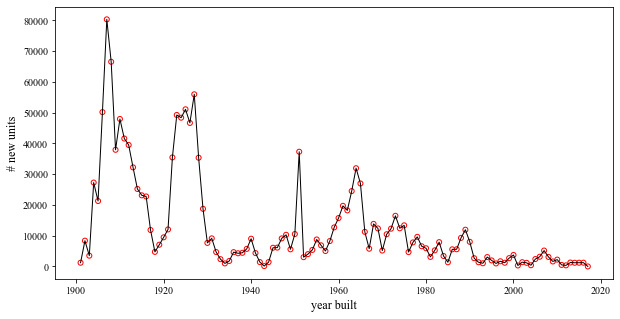

In [34]:
units_by_yr = asr[
    (asr['any_rc_eligibility'] == 1) &
    (asr['year_built_max'] > 1900) &
    (asr['year_built_max'] < 2100)].groupby('year_built_max').agg({'total_units': 'sum'}).reset_index()

fig, ax = plt.subplots(figsize=(10,5))
plt.rcParams["font.family"] = 'times new roman'
ax.scatter(units_by_yr['year_built_max'], units_by_yr['total_units'], s=25, facecolors='none', edgecolors='r')
ax.plot(units_by_yr['year_built_max'], units_by_yr['total_units'], lw=1, c='k', )

_ = ax.set_xlabel("year built", fontsize=12)
_ = ax.set_ylabel("# new units", fontsize=12)
# _ = ax.set_title("SF New Construction: Rent-control eligible use-codes", fontsize=20)

plt.savefig('../../../2021_02_summer/evic_paper/fig_1.jpg', dpi=300, bbox_inches='tight')

#### Fig 2

In [35]:
rc_pop = asr[
    (asr['any_rc_eligibility'] == 1) & (asr['year_built_max'] > 1953) &
    (asr['year_built_max'] < 2007) & (asr['total_units'] > 0)]

yr_vs_ev = rc_pop.groupby('year_built_max').agg({
    'ev_per_unit': 'mean',
}).reset_index()

yr_vs_ev1 = yr_vs_ev[(yr_vs_ev['year_built_max'] < 1980) &
                     (yr_vs_ev['year_built_max'] >= 1953)]
yr_vs_ev2 = yr_vs_ev[(yr_vs_ev['year_built_max'] >= 1980) &
                     (yr_vs_ev['year_built_max'] <= 2007)]

In [36]:
rc_pop.shape

(54388, 33)

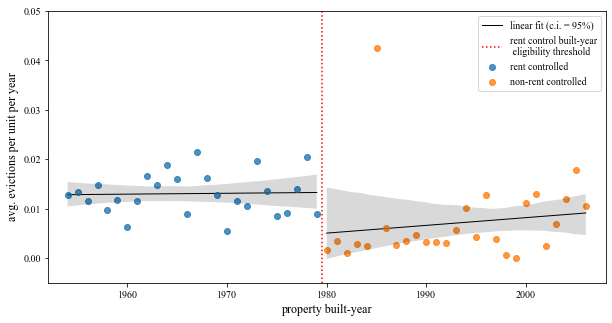

In [37]:
fig, ax = plt.subplots(figsize=(10,5))

sns.regplot(
    x='year_built_max', y='ev_per_unit', data=yr_vs_ev1, ax=ax, truncate=True,
    label='rent controlled', line_kws={'color':'k', 'lw':1, 'label':'linear fit (c.i. = 95%)', 'zorder': 0})
sns.regplot(
    x='year_built_max', y='ev_per_unit', data=yr_vs_ev2, ax=ax, truncate=True,
    label='non-rent controlled', line_kws={'color':'k', 'lw':'1',  'zorder': 0})
ax.axvline(1979.5, ls=':', c='r', label='rent control built-year\n eligibility threshold')
ax.legend()
_ = ax.set_xlabel("property built-year", fontsize=12)
_ = ax.set_ylabel("avg. evictions per unit per year", fontsize=12,
#                   rotation=0,
#                   labelpad=70
                 )
# _ = ax.set_title("SF Eviction Rates (2007-2016)\nfor Multi-family Residential Addresses", fontsize=20)
ax.set_ylim((-0.005, 0.05))
ax.set_xlim((1952, 2008))
# ax.annotate('rent control \nbuilt-year threshold', xy=(1979, 0.04),  xycoords='data',
#             xytext=(0.3, 0.8), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black',headlength=10, width=0.5, headwidth=10),
#             horizontalalignment='center', verticalalignment='center', fontsize=12
#             )
plt.savefig('../../../2021_02_summer/evic_paper/fig_2.jpg', dpi=300, bbox_inches='tight')

#### Fig 3

In [38]:
sf = gpd.read_file('../../../2021_02_summer/evic_paper/sf_boundary.shp')

In [39]:
ev['geometry'] = ev.apply(lambda x: Point(x['longitude_asr'], x['latitude_asr']), axis=1)

In [40]:
ev_gpd = gpd.GeoDataFrame(ev, geometry='geometry')

In [41]:
ev_gpd.crs = 'EPSG:4326'

In [42]:
ev_gpd = ev_gpd.to_crs(sf.crs)

In [43]:
ev_gpd['proj_x'] = ev_gpd.geometry.x
ev_gpd['proj_y'] = ev_gpd.geometry.y

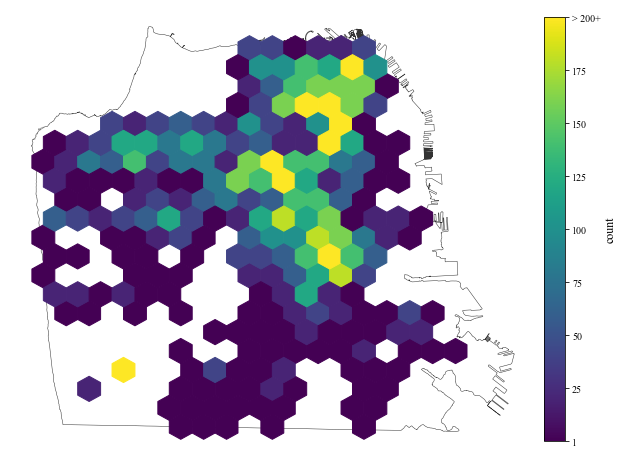

In [45]:
fig, ax = plt.subplots(figsize=(10,10))
sf.plot(facecolor='None', edgecolor='k', ax=ax, lw=0.5, alpha=0.8)
hb = ax.hexbin(x=ev_gpd['proj_x'], y=ev_gpd['proj_y'], mincnt=1,
               bins=[0,20,40,60,80,100,120,140,160,180,200],
               gridsize=18)
cb = fig.colorbar(hb, ax=ax, fraction=0.038,pad=0.01)
cb.set_label('count', fontsize=12)
cb.set_ticks([1,2.25,3.5,4.75,6,7.25,8.5,9.75,11])
cb.set_ticklabels([1,25, 50,75,100,125,150,175,'> 200+'])
ax.axis('off')
plt.savefig('../../../2021_02_summer/evic_paper/fig_3.jpg', dpi=300, bbox_inches='tight')

#### Appendix A

In [46]:
ev.loc[pd.isnull(ev['type']), 'type'] = 'unknown'
type_counts = ev.groupby(['built_1980', 'type']).agg(count=('index_ev', 'nunique')).reset_index()
pre_sums = type_counts.groupby('built_1980')['count'].sum()

type_counts = type_counts.pivot(index='type', columns='built_1980', values='count')
type_counts['pct_after'] = np.round(type_counts['after'] / pre_sums['after'] * 100, 1)
type_counts['pct_before'] = np.round(type_counts['before'] / pre_sums['before'] * 100, 1)
type_counts.reset_index(inplace=True)
type_counts.set_index('type', inplace=True, drop=True)

In [47]:
type_counts = type_counts.sort_values('pct_before', ascending=False)[['before','pct_before','after','pct_after']]

In [48]:
type_counts = type_counts.astype(str)

In [49]:
type_counts['after'] = type_counts['after'].str.split('.').str[0]
type_counts['before'] = type_counts['before'].str.split('.').str[0]
type_counts = type_counts.replace('nan', '--', regex=True)

In [50]:
type_counts

built_1980,before,pct_before,after,pct_after
type,,,,
unknown,5066,36.8,44,23.3
Breach of Lease Agreement,3031,22.0,66,34.9
Nuisance,1621,11.8,28,14.8
OMI,1177,8.5,3,1.6
Capital Improvement,518,3.8,--,--
Non-payment of Rent,487,3.5,11,5.8
Habitual Late Payment of Rent,399,2.9,4,2.1
ELLIS,346,2.5,--,--
Illegal Use of Unit,199,1.4,1,0.5


# RD 

In [51]:
bandwidth = 27

df = asr[
    (asr['any_rc_eligibility'] == 1) & (asr['year_built_max'] > 1980 - bandwidth) &
    (asr['year_built_max'] < 1980 + bandwidth) & (asr['total_units'] > 0)].copy()

In [52]:
df.shape

(54388, 33)

In [104]:
54388 - 53493

895

In [53]:
df['rent_control'] = False
df.loc[df['pre_1980'] == True, 'rent_control'] = True
df['year_built_centered'] = df['year_built_max'] - 1980

In [54]:
df['ev_count'].sum()

2370

### Model 1

In [55]:
rd = smf.ols(
    "ev_per_unit ~ rent_control + year_built_centered*rent_control",
    data=df)

In [56]:
fitted = rd.fit()

In [57]:
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:            ev_per_unit   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.953
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           2.68e-05
Time:                        12:41:51   Log-Likelihood:                 19572.
No. Observations:               54388   AIC:                        -3.914e+04
Df Residuals:                   54384   BIC:                        -3.910e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

### Model 2: Standard RDD + Property Characteristics

In [58]:
rd2_df = df[(df['total_sqft'] > 50) & (df['total_value'] > 100)].copy()

In [59]:
rd2 = smf.ols(
    "ev_per_unit ~ rent_control + year_built_centered*rent_control + "
    "np.log(total_value):np.log(total_sqft) + np.log(total_units)",
    data=rd2_df)

In [60]:
fitted2 = rd2.fit()
print(fitted2.summary())

                            OLS Regression Results                            
Dep. Variable:            ev_per_unit   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     91.86
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           1.28e-96
Time:                        12:41:55   Log-Likelihood:                 20170.
No. Observations:               53600   AIC:                        -4.033e+04
Df Residuals:                   53594   BIC:                        -4.028e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

### Model 3: Standard RDD + Property Characteristics + Census Tract Attributes

In [61]:
census_df = pd.read_csv('../data/census_tract_acs_data.csv', dtype={'tract_id': str})

In [62]:
asr['tract_id'] = asr['fipscd'].astype(str).str.zfill(15).str[:11]

In [63]:
asr = pd.merge(asr, census_df, on='tract_id', how='left')

In [64]:
dropped_parcels = len(asr[pd.isnull(asr['median_hh_income'])])
dropped_evs = asr[pd.isnull(asr['median_hh_income'])]['ev_count'].sum()
print('Dropped {0} parcels ({1}%) and {2} evictions merging on tract-level census data'.format(
    dropped_parcels, np.round(dropped_parcels/len(asr)*100, 2), dropped_evs))

Dropped 301 parcels (0.02%) and 3 evictions merging on tract-level census data


In [65]:
rd3_df = asr[
    (asr['any_rc_eligibility'] == 1) & (asr['year_built_max'] > 1980 - bandwidth) &
    (asr['year_built_max'] < 1980 + bandwidth) & (asr['total_units'] > 0) & 
    (asr['total_sqft'] > 50) & (asr['total_value'] > 100)].copy()
rd3_df['rent_control'] = False
rd3_df.loc[rd3_df['pre_1980'] == True, 'rent_control'] = True
rd3_df['year_built_centered'] = rd3_df['year_built_max'] - 1980

In [66]:
rd3_df['pct_non_white'] = 1 - (rd3_df['white_only_pop'] / rd3_df['total_pop_race'])
rd3_df['pct_black'] = (rd3_df['black_only_pop'] / rd3_df['total_pop_race'])
rd3_df['pct_black_multi'] = (rd3_df['black_only_pop'] + rd3_df['multiracial_pop']) / rd3_df['total_pop_race']
rd3_df['pct_latino'] = rd3_df['hispanic_pop'] / rd3_df['total_pop_race']
rd3_df['pct_occ_units_rental'] = rd3_df['total_rental_tenure'] / rd3_df['total_occupied_units']
rd3_df['pct_renter_pop'] = rd3_df['total_renter_pop'] / rd3_df['total_pop_tenure']
rd3_df['pct_rentals_pre2000_movein'] = (
    rd3_df['total_rental_tenure'] - rd3_df['renter_movein_2005_later'] - rd3_df['renter_movein_2000_2004']) / (
    rd3_df['total_rental_tenure'])
rd3_df['pct_renter_same_house_last_yr'] = rd3_df['renter_non_mover'] / rd3_df['total_renter_pop']

In [67]:
rd3_df = rd3_df[(rd3_df['median_movein_yr_owners'] > 0) & (rd3_df['median_movein_yr_renters'] > 0)]
rd3_df['yrs_before_2011_median_movein_yr_rent'] = rd3_df['median_movein_yr_renters'] - rd3_df['median_movein_yr_renters']
rd3_df['yrs_before_2011_median_movein_yr_own'] = 2011 - rd3_df['median_movein_yr_owners']
rd3_df['median_movein_yr_rent_std'] = (rd3_df['median_movein_yr_renters'] - rd3_df['median_movein_yr_renters'].mean()) / rd3_df['median_movein_yr_renters'].std()
rd3_df['median_movein_yr_own_std'] = (rd3_df['median_movein_yr_owners'] - rd3_df['median_movein_yr_owners'].mean()) / rd3_df['median_movein_yr_owners'].std()

In [68]:
rd3_df['pct_recent_mover_rent'] = 1 - (rd3_df['renter_non_mover'] / rd3_df['total_renter_pop'])

In [69]:
rd3 = smf.ols(
    "ev_per_unit ~ rent_control + year_built_centered*rent_control + "
    "np.log(total_value):np.log(total_sqft) + np.log(total_units) + "
    "np.log(median_hh_income) + "
    "pct_non_white + "
    "pct_occ_units_rental + "
    "pct_rentals_pre2000_movein",
    data=rd3_df)

In [70]:
fitted3 = rd3.fit()
print(fitted3.summary())

                            OLS Regression Results                            
Dep. Variable:            ev_per_unit   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     47.25
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           1.27e-85
Time:                        12:42:10   Log-Likelihood:                 20951.
No. Observations:               53493   AIC:                        -4.188e+04
Df Residuals:                   53483   BIC:                        -4.179e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [71]:
rd3b = smf.ols(
    "ev_per_unit ~ rent_control + year_built_centered*rent_control + "
    "np.log(total_value):np.log(total_sqft) + np.log(total_units) + "
#     "np.log(median_hh_income) + "
    "pct_latino +"
#     "median_movein_yr_rent_std +"
#     "pct_recent_mover_rent +"
    "pct_occ_units_rental",
#     "pct_rentals_pre2000_movein",
    data=rd3_df)
fitted3b = rd3b.fit()
print(fitted3b.summary())

                            OLS Regression Results                            
Dep. Variable:            ev_per_unit   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     64.24
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           1.32e-92
Time:                        12:42:14   Log-Likelihood:                 20963.
No. Observations:               53493   AIC:                        -4.191e+04
Df Residuals:                   53485   BIC:                        -4.184e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

### Model 4: Standard RDD + Property Characteristics + Census Tract Attributes + Neighborhood Fixed Effects

In [72]:
rd4_df = rd3_df.copy()

In [73]:
rd4 = smf.ols(
    "ev_per_unit ~ rent_control + year_built_centered*rent_control + "
    "np.log(total_value):np.log(total_sqft) + np.log(total_units) + "
    "pct_latino + "
    "pct_occ_units_rental + "
    "nbd_code",
    data=rd4_df)

In [74]:
fitted4 = rd4.fit()
print(fitted4.summary())

                            OLS Regression Results                            
Dep. Variable:            ev_per_unit   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     6.377
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           5.01e-65
Time:                        12:42:20   Log-Likelihood:                 21000.
No. Observations:               53493   AIC:                        -4.183e+04
Df Residuals:                   53410   BIC:                        -4.110e+04
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [75]:
rd4b = smf.ols(
    "ev_per_unit ~ rent_control + year_built_centered*rent_control + "
    "np.log(total_value):np.log(total_sqft) + np.log(total_units) + "
    "pct_latino + "
    "pct_occ_units_rental + "
    "nbd_code",
    data=rd4_df)
fitted4b = rd4b.fit()
print(fitted4b.summary())

                            OLS Regression Results                            
Dep. Variable:            ev_per_unit   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     6.377
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           5.01e-65
Time:                        12:42:29   Log-Likelihood:                 21000.
No. Observations:               53493   AIC:                        -4.183e+04
Df Residuals:                   53410   BIC:                        -4.110e+04
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [80]:
rd4_df['geometry'] = rd4_df.apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)
rd4_gdf = gpd.GeoDataFrame(rd4_df, geometry='geometry')
rd4_gdf.crs = 'EPSG:4326'

In [77]:
nbd_gdf = gpd.read_file('/Users/max/Documents/cal/2021_02_summer/evic_paper/SF Find Neighborhoods/geo_export_b9533012-1016-4bb8-a58a-ce8a0b05319f.shp')

In [89]:
rd4_nbd_df = gpd.sjoin(rd4_gdf, nbd_gdf,op='within', how='inner')

In [90]:
rd4_nbd_df.shape

(53493, 81)

In [86]:
nbd_gdf.columns

Index(['link', 'name', 'geometry'], dtype='object')

In [97]:
rd4_nbd_df[rd4_nbd_df['name'] == 'Chinatown']['ev_count'].sum()

0

### rerun models on exact same data

In [99]:
rd_rd4_df = smf.ols(
    "ev_per_unit ~ rent_control + year_built_centered*rent_control",
    data=rd4_df)
rd_rd4_df_fitted = rd_rd4_df.fit()
print(rd_rd4_df_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:            ev_per_unit   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.483
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           5.27e-05
Time:                        12:54:21   Log-Likelihood:                 20751.
No. Observations:               53493   AIC:                        -4.149e+04
Df Residuals:                   53489   BIC:                        -4.146e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [102]:
rd2_rd4_df = smf.ols(
    "ev_per_unit ~ rent_control + year_built_centered*rent_control + "
    "np.log(total_value):np.log(total_sqft) + np.log(total_units)",
    data=rd4_df)
rd2_rd4_df_fitted = rd2_rd4_df.fit()
print(rd2_rd4_df_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:            ev_per_unit   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     82.04
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           4.11e-86
Time:                        12:57:07   Log-Likelihood:                 20944.
No. Observations:               53493   AIC:                        -4.188e+04
Df Residuals:                   53487   BIC:                        -4.182e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [ ]:
rd4_df['median_hh_income_std'] = (rd4_df['median_hh_income'] - rd4_df['median_hh_income'])/

In [120]:
rd3_rd4_df = smf.ols(
    "ev_per_unit ~ rent_control + year_built_centered*rent_control + "
    "np.log(total_value):np.log(total_sqft) + np.log(total_units) + "
    "pct_latino +"
    "pct_occ_units_rental",
    data=rd4_df)
rd3_rd4_df_fitted = rd3_rd4_df.fit()
print(rd3_rd4_df_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:            ev_per_unit   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     64.24
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           1.32e-92
Time:                        14:44:06   Log-Likelihood:                 20963.
No. Observations:               53493   AIC:                        -4.191e+04
Df Residuals:                   53485   BIC:                        -4.184e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [107]:
df[~df['index'].isin(rd4_df.index)]['ev_count'].sum()

115

In [109]:
df[~df['index'].isin(rd4_df.index)].shape

(895, 35)

In [122]:
rd4_df.groupby('rent_control')['ev_per_unit'].mean()

rent_control
False    0.005407
True     0.013109
Name: ev_per_unit, dtype: float64